--------------------------------
## Basic regression: Predict fuel efficiency
---------------------------------

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. 

To do this, we'll provide the model with a description of many automobiles from that time period. 

This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

2.7.0


#### download the data

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", 
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
                                    cache_dir=r'D:\MYLEARN\datasets\keras')

print('File location : {}'.format(dataset_path))

File location : D:\MYLEARN\datasets\keras\datasets\auto-mpg.data


#### import into pandas

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, 
                          names=column_names,
                          na_values = "?", 
                          comment='\t',
                          sep=" ", 
                          skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data
The dataset contains a few unknown values. 

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# drop NA rows.
dataset = dataset.dropna()

In [8]:
dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

The "Origin" column is really categorical, not numeric. So convert that to a one-hot:

In [9]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
# origin = dataset.pop('Origin')
# dataset['USA']    = (origin == 1)*1.0
# dataset['Europe'] = (origin == 2)*1.0
# dataset['Japan']  = (origin == 3)*1.0
# dataset.tail()

##### Split the data into train and test
Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset  = dataset.drop(train_dataset.index)

## Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.

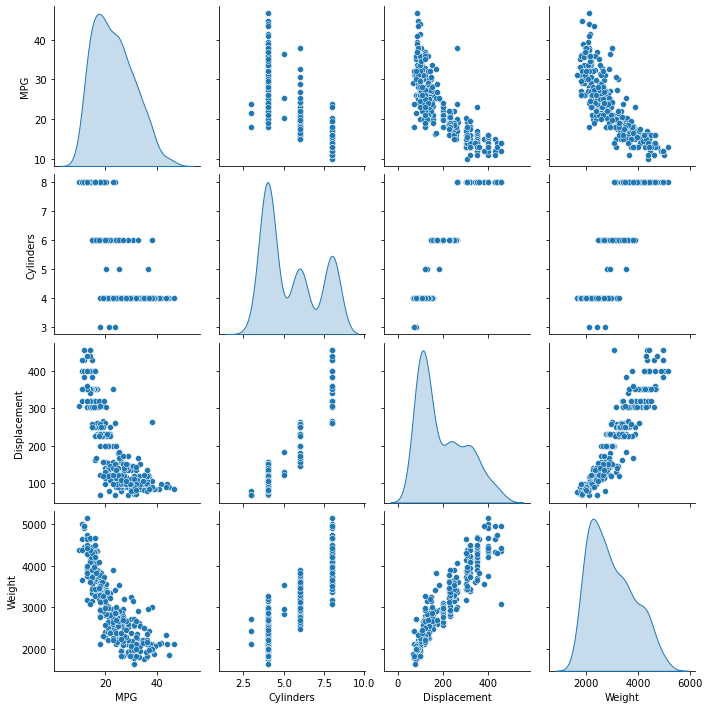

In [13]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde");

In [14]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split features from labels
Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [15]:
train_labels = train_dataset.pop('MPG')
test_labels  = test_dataset.pop('MPG')

## Normalize the data

In [16]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data  = norm(test_dataset)

## Build the model

Here, we'll use a __Sequential model__ with 2 densely connected hidden layers and an output layer that returns a single, continuous value. 

The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [17]:
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')

In [21]:
def build_model():
    model = keras.Sequential([
                                layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                                layers.Dense(64, activation='relu'),
                                layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [22]:
model = build_model()

## Inspect the model
Use the .summary method to print a simple description of the model

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [20]:
64*64 + 64

4160

Now try out the model. Take a batch of 10 examples from the training data and call model.predict on it.

In [21]:
example_batch  = normed_train_data[:10]

example_result = model.predict(example_batch)
example_result

array([[ 0.42690426],
       [ 0.23472969],
       [-0.10458219],
       [ 0.25367105],
       [ 0.39165515],
       [-0.08040045],
       [ 0.41889596],
       [ 0.47658372],
       [ 0.02836484],
       [ 0.40820304]], dtype=float32)

## Train the model
Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [24]:
EPOCHS = 1000

history = model.fit(
                    normed_train_data, 
                    train_labels,
                    epochs=EPOCHS, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[tfdocs.modeling.EpochDots(report_every=100)]
                    )


Epoch: 0, loss:588.7361,  mae:23.0018,  mse:588.7361,  val_loss:584.3846,  val_mae:22.8853,  val_mse:584.3846,  
....................................................................................................
Epoch: 100, loss:5.9800,  mae:1.7146,  mse:5.9800,  val_loss:7.9105,  val_mae:2.1655,  val_mse:7.9105,  
....................................................................................................
Epoch: 200, loss:5.3483,  mae:1.5801,  mse:5.3483,  val_loss:8.3072,  val_mae:2.0841,  val_mse:8.3072,  
....................................................................................................
Epoch: 300, loss:4.9006,  mae:1.4880,  mse:4.9006,  val_loss:8.0227,  val_mae:2.1429,  val_mse:8.0227,  
....................................................................................................
Epoch: 400, loss:4.2238,  mae:1.3624,  mse:4.2238,  val_loss:8.6071,  val_mae:2.1386,  val_mse:8.6071,  
..............................................................

In [26]:
# Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.537869,1.017138,2.537869,8.779229,2.284628,8.779229,995
996,2.280765,0.931718,2.280765,8.973405,2.281550,8.973405,996
997,2.390000,0.986768,2.390000,9.209630,2.305011,9.209630,997
998,2.469902,0.986583,2.469902,8.596411,2.247371,8.596411,998
999,2.318656,0.923001,2.318656,9.304179,2.291790,9.304179,999


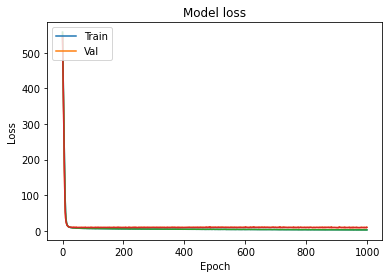

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('Model performance')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left');

Text(0, 0.5, 'MAE [MPG]')

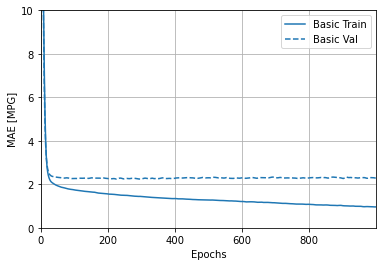

In [28]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

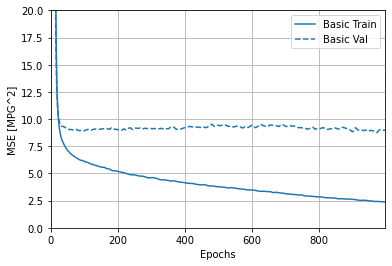

In [29]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs.

Let's update the model.fit call to automatically stop training when the validation score doesn't improve. 

We'll use an __EarlyStopping__ callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [30]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, 
                          train_labels, 
                          epochs=EPOCHS, 
                          validation_split = 0.2, 
                          verbose=0, 
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:586.4925,  mae:23.0054,  mse:586.4925,  val_loss:582.3533,  val_mae:22.9072,  val_mse:582.3533,  
..........................................................................

Text(0, 0.5, 'MAE [MPG]')

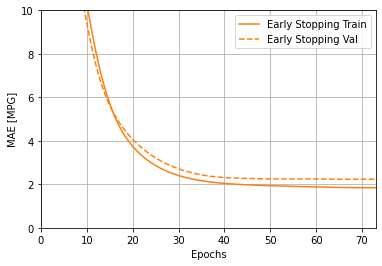

In [31]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good?

Let's see how well the model generalizes by using the test set, which we did not use when training the model. 

In [30]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.5328 - mae: 1.8279 - mse: 5.5328
Testing set Mean Abs Error:  1.83 MPG


## Make predictions
Finally, predict MPG values using data in the testing set:

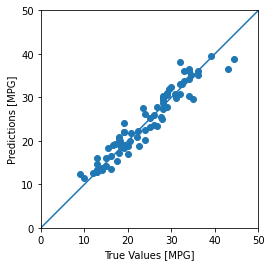

In [31]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

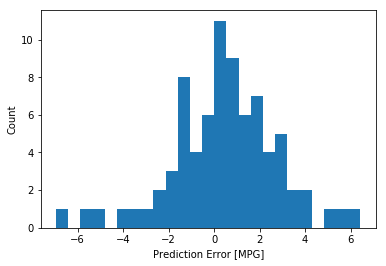

In [89]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.